In [102]:
import os
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [103]:
DIR_TFRECORDS = 'data_small_tfrecords'
DATA_TRAIN = glob('./'+DIR_TFRECORDS+'/*.tfrecords')

ANCHORS = np.array(
    [
        [1.73145, 1.3221],
        [4.00944, 3.19275],
        [8.09892, 5.05587],
        [4.84053, 9.47112],
        [10.0071, 11.2364]
    ]
)

GRID_SIZE = 32
GRID_H, GRID_W = 19, 19
IMG_H, IMG_W = 608, 608  # GRID_H * GRID_SIZE = 19 * 32 = 608

BATCH_SIZE = 1

## Estimator

In [57]:
def input_fn_train(data_file):
    def parse_record(record):
        # dictionary as per saved TFRecord
        keys_to_features = {
            'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
            'num_objects': tf.FixedLenFeature(shape=(), dtype=tf.string),
            'targets': tf.FixedLenFeature(shape=(), dtype=tf.string),
            'flag_object': tf.FixedLenFeature(shape=(), dtype=tf.string),
            'box_adjustments': tf.FixedLenFeature(shape=(), dtype=tf.string)
        }

        # parse record
        parsed = tf.parse_single_example(record, keys_to_features)

        # decode image
        img = tf.decode_raw(parsed['img'], tf.float32)
        img = tf.reshape(img, [IMG_H, IMG_W, 3])
        
        # get num_objects
        num_objects = tf.decode_raw(parsed['num_objects'], tf.float32)
        num_objects = tf.cast(num_objects[0], tf.int32)
        
        # decode label
        targets = tf.decode_raw(parsed['targets'], tf.float32)
        targets = tf.reshape(targets, [num_objects, 5])

        # decode other matrices
        flag_object = tf.decode_raw(parsed['flag_object'], tf.float32)
        flag_object = tf.reshape(flag_object, [GRID_H, GRID_W, ANCHORS.shape[0], 1])
        box_adjustments = tf.decode_raw(parsed['box_adjustments'], tf.float32)
        box_adjustments = tf.reshape(box_adjustments, [GRID_H, GRID_W, ANCHORS.shape[0], 5])

        return {'img': img}, targets, flag_object, box_adjustments
    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.shuffle(buffer_size=1000)
    Nonedataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    
    iterator = dataset.make_one_shot_iterator()
    features, targets, flag_object, box_adjustments = iterator.get_next()
    
    return features, {'targets': targets, 'flag_object': flag_object, 'box_adjustments': box_adjustments}

def get_feature_columns():
    img = tf.feature_column.numeric_column('img', dtype=tf.float32)
    
    return img

def model_fn(features, labels, mode, params):
    # input layer
    net = tf.feature_column.input_layer(features, params['feature_columns'])
    imgs = tf.reshape(net, [-1, IMG_SIZE[0], IMG_SIZE[1], 1])
    
    # CNN
    net = tf.layers.conv2d(imgs, filters=8, kernel_size=5)
    net = tf.layers.max_pooling2d(net, pool_size=3, strides=1)
    net = tf.layers.conv2d(net, filters=8, kernel_size=5)
    net = tf.layers.max_pooling2d(net, pool_size=3, strides=1)
    net = tf.layers.conv2d(net, filters=8, kernel_size=3)
    net = tf.layers.flatten(net)
    net = tf.layers.dense(net, units=1024, activation=tf.nn.relu)
    net = tf.layers.dense(net, units=1024, activation=tf.nn.relu)
    
    predictions = tf.layers.dense(net, params['n_dof'])
    
    ## PREDICT
    if mode == tf.estimator.ModeKeys.PREDICT:
        outputs = {
            'output': predictions
        }
        return tf.estimator.EstimatorSpec(mode, predictions=outputs)
    
    # compute loss
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    loss = loss
    tf.summary.scalar('loss_summary', loss)
    
    # compute evaluation metrics
    mse = tf.metrics.mean_squared_error(labels=labels, predictions=predictions, name='mse_op')
    metrics = {'mse': mse}
    tf.summary.scalar('mse', mse[1])
    
    ## EVALUATE
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    ## TRAIN
    assert mode == tf.estimator.ModeKeys.TRAIN
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

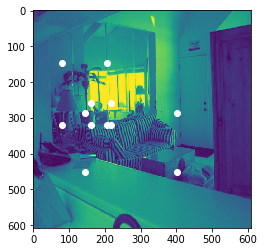

In [119]:
tf.reset_default_graph()
f, l = input_fn_train(DATA_TRAIN)

with tf.Session() as sess:
    f, l = sess.run([f,l])

l = l['targets']

plt.imshow(f['img'][:,:,0])
for idx_object in range(l.shape[0]):
    plt.scatter((l[idx_object,1]-l[idx_object,3]/2)*IMG_W, (l[idx_object,0]-l[idx_object,2]/2)*IMG_H, color='w')
    plt.scatter((l[idx_object,1]-l[idx_object,3]/2)*IMG_W, (l[idx_object,0]+l[idx_object,2]/2)*IMG_H, color='w')
    plt.scatter((l[idx_object,1]+l[idx_object,3]/2)*IMG_W, (l[idx_object,0]-l[idx_object,2]/2)*IMG_H, color='w')
    plt.scatter((l[idx_object,1]+l[idx_object,3]/2)*IMG_W, (l[idx_object,0]+l[idx_object,2]/2)*IMG_H, color='w')
plt.show()